In [1]:
import numpy as np
import sys, os, re
import tensorflow as tf

ROOT_DIR = os.path.realpath('..')
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

from char2vec.utils import *
from char2vec.embed import *


## Show a few lines from the corpus:

In [2]:
corpus_path = os.path.join(ROOT_DIR, 'docs/small_corpus.txt') 
with open(corpus_path, 'r') as f:
    for i in range(6):
        sys.stdout.write(f.readline())

Small corpus copied from Wikipedia page on Monty Python.
https://en.wikipedia.org/wiki/Monty_Python

BEGIN QUOTE

Monty Python (also collectively known as the Pythons)[2][3] are a British surreal comedy group who created the sketch comedy television show Monty Python's Flying Circus, which first aired on the BBC in 1969. Forty-five episodes were made over four series. The Python phenomenon developed from the television series into something larger in scope and impact, including touring stage shows, films, numerous albums, several books, and musicals. The Pythons' influence on comedy has been compared to the Beatles' influence on music.[4][5][6] Regarded as enduring icons of 1970s pop culture, their sketch show has been referred to as being “an important moment in the evolution of television comedy".[7]


## Create a model and train on the corpus:

In [3]:
CONFIG.show()

Showing CONFIG
  BATCH = 32
  D = 10
  GPU = False
  SHUFF_BUFFER = 10000
  TOTAL_STEPS = 30001
  WINDOW_SIZES = [1, 2, 3]


In [4]:
print('Alphabet:', ALPHABET.encode('utf-8'))
print('Unknown token rep:', '"~"')

Alphabet: b'abcdefghijklmnopqrstuvwxyz1234567890,.()[]"\' -\n'
Unknown token rep: "~"


In [5]:
m = Char2Vec(corpus_path, config=CONFIG, alphabet=ALPHABET, unk='~')

In [6]:
# Simply call m.train() to run training:
%timeit -n1 -r1 m.train()

Training 30001 steps with batch size 32...
Step       0:  loss=0.6934691667556763
Step    3000:  loss=0.0849926769733429
Step    6000:  loss=0.07934650033712387
Step    9000:  loss=0.0826152041554451
Step   12000:  loss=0.07706891745328903
Step   15000:  loss=0.0785064548254013
Step   18000:  loss=0.07765258103609085
Step   21000:  loss=0.07670509815216064
Step   24000:  loss=0.0773739293217659
Step   27000:  loss=0.08010494709014893
Step   30000:  loss=0.07977274805307388
Training 501 steps with batch size 512...
Step       0:  loss=0.07820867747068405
Step     500:  loss=0.07689770311117172
3min 4s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Visualize the embeddings:
The learned parameters can be accessed by `m.U_` and `m.W_`. Here `m.U_` is the embedding matrix, and `m.W_` is the matrix to recover context vector from embedded representations.

In [7]:
U = m.U_

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [9]:
def scatter2d_with_annotation(arr, text, xcol=0, ycol=1, fontsize=7, show=False, adjust_text_boo=True, **kwargs):
    assert len(arr)==len(text)
    fig, ax = plt.subplots(**kwargs)
    xarr = arr[:, xcol]
    yarr = arr[:, ycol]
    plt_texts = []
    for i in range(len(text)):
        plt.scatter(xarr[i], yarr[i])
        plt_texts.append(plt.text(xarr[i], yarr[i], text[i], fontsize=fontsize))
    if adjust_text_boo:
        from adjustText import adjust_text
        adjust_text(plt_texts, arrowprops=dict(arrowstyle="->", color='grey', lw=0.5))
    if show:
        plt.show()
    return fig, ax

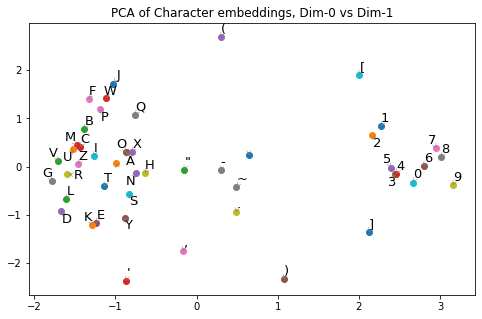

In [10]:
p = PCA()
U2 = p.fit_transform(U)
texts = m._tokenizer.alphabet + [m._tokenizer.unk]
fig, ax = scatter2d_with_annotation(
            U2, [s.upper() for s in texts],
            0,1,
            figsize=(8,5), fontsize=13)
plt.title('PCA of Character embeddings, Dim-0 vs Dim-1')
#plt.savefig('./PCA-0-1.png')
plt.show()

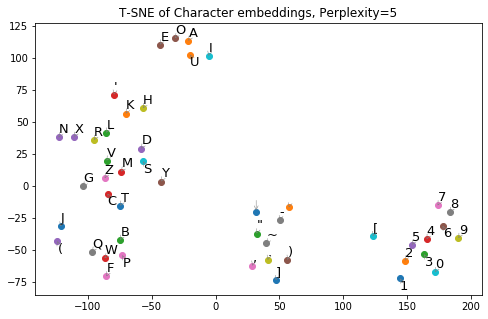

In [11]:
from sklearn.manifold import TSNE
U3 = TSNE(n_components=2, perplexity=5).fit_transform(U)
fig, ax = scatter2d_with_annotation(
            U3, [s.upper() for s in texts],
            0,1,
            figsize=(8,5), fontsize=13)
plt.title('T-SNE of Character embeddings, Perplexity=5')
#plt.savefig('./T-SNE_p5.png')
plt.show()

## Interactive training:
(For custom training schedule)

In [12]:
m = Char2Vec(corpus_path)
m._create_graph()

with m._graph.as_default():
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())    

In [13]:
m._train(sess, n_steps=20001, batch_size=8, print_every=4000)

Training 20001 steps with batch size 8...
Step       0:  loss=0.6927655935287476
Step    4000:  loss=0.08189480006694794
Step    8000:  loss=0.08063329756259918
Step   12000:  loss=0.07972197979688644
Step   16000:  loss=0.07762684673070908
Step   20000:  loss=0.07243742793798447


In [14]:
m._train(sess, n_steps=501, batch_size=64, print_every=500)

Training 501 steps with batch size 64...
Step       0:  loss=0.07782260328531265
Step     500:  loss=0.0790477842092514


In [15]:
m._train(sess, n_steps=501, batch_size=512, print_every=500)

Training 501 steps with batch size 512...
Step       0:  loss=0.07860081642866135
Step     500:  loss=0.07878997921943665


In [16]:
sess.close()